# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = '^DJI'
#symbol = 'DJA'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [4]:
use_adj = False

Fetch symbol data from internet; use cache if available.

In [5]:
ts = pf.fetch_timeseries(symbol)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,17.66
1928-01-03,17.76,17.76,17.76,17.76,0,17.76
1928-01-04,17.72,17.72,17.72,17.72,0,17.72
1928-01-05,17.55,17.55,17.55,17.55,0,17.55
1928-01-06,17.66,17.66,17.66,17.66,0,17.66


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [6]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1956-03-05,46.06,46.06,46.06,46.06,3090000,46.06
1956-03-06,46.04,46.04,46.04,46.04,2770000,46.04
1956-03-07,46.01,46.01,46.01,46.01,2380000,46.01
1956-03-08,46.12,46.12,46.12,46.12,2500000,46.12
1956-03-09,46.70,46.70,46.70,46.70,3430000,46.70


Add technical indicator: 50 day ma and 200 day ma

In [7]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
1956-03-05,46.06,46.06,46.06,46.06,3090000,46.06,nan,nan
1956-03-06,46.04,46.04,46.04,46.04,2770000,46.04,nan,nan
1956-03-07,46.01,46.01,46.01,46.01,2380000,46.01,nan,nan
1956-03-08,46.12,46.12,46.12,46.12,2500000,46.12,nan,nan
1956-03-09,46.70,46.70,46.70,46.70,3430000,46.70,nan,nan


Finalize the time series before implementing trading strategy

In [8]:
ts, start = pf.finalize_timeseries(ts, start)
ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
1957-03-04,44.06,44.06,44.06,44.06,1890000,44.06,44.76,46.36
1957-03-05,44.22,44.22,44.22,44.22,1860000,44.22,44.71,46.35
1957-03-06,44.23,44.23,44.23,44.23,1840000,44.23,44.68,46.34
1957-03-07,44.21,44.21,44.21,44.21,1830000,44.21,44.63,46.33
1957-03-08,44.07,44.07,44.07,44.07,1630000,44.07,44.59,46.32


Plot closing price along with moving averages

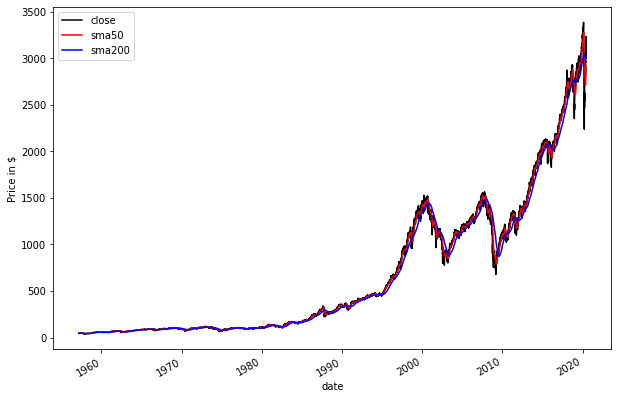

In [9]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [10]:
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [11]:
pf.TradeLog.cash = capital

import time
t0 = time.time()

"""
# This is the slowest (2.42 s)
for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

# This is still slow (2.53 s)
for i, (index, row) in enumerate(ts.iterrows()):

    date = index
    high = row['high']
    low = row['low']
    close = row['close']
    sma50 = row['sma50']
    sma200 = row['sma200']


# using .at[] is fast (832 ms)
for i, index in enumerate(ts.index):

    date = index
    high = ts.at[index, 'high']
    low = ts.at[index, 'low']
    close = ts.at[index, 'close']
    sma50 = ts.at[index, 'sma50']
    sma200 = ts.at[index, 'sma200']

# using itertuples is fastest for looping (378 ms)
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
"""

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high; low = row.low; close = row.close; 
    end_flag = pf.is_last_row(ts, i)
    shares = 0
    
    # close all positions on last trade day
    if end_flag:
        shares = tlog.sell(date, close)
    # buy
    elif (tlog.shares == 0
          and row.sma50 > row.sma200
          and ts['sma50'][i-1] <= ts['sma200'][i-1]):

        # enter buy in trade log
        shares = tlog.buy(date, close)  
    # sell
    elif (tlog.shares > 0
          and row.sma50 < row.sma200
          and ts['sma50'][i-1] >= ts['sma200'][i-1]):

        # enter sell in trade log
        shares = tlog.sell(date, close)

    if shares > 0:
        print("{0} BUY  {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    elif shares < 0:
        print("{0} SELL {1} {2} @ {3:.2f}".format(
              date, -shares, symbol, close))

    # record daily balance
    dbal.append(date, high, low, close)  

t1 = time.time()
total = t1-t0
print(total)
        

1957-06-03 00:00:00 BUY  211 ^GSPC @ 47.37
1957-09-26 00:00:00 SELL 211 ^GSPC @ 42.57
1958-05-08 00:00:00 BUY  204 ^GSPC @ 43.99
1959-10-30 00:00:00 SELL 204 ^GSPC @ 57.52
1959-12-30 00:00:00 BUY  196 ^GSPC @ 59.77
1960-02-15 00:00:00 SELL 196 ^GSPC @ 55.17
1961-01-04 00:00:00 BUY  185 ^GSPC @ 58.36
1962-05-07 00:00:00 SELL 185 ^GSPC @ 66.02
1963-01-03 00:00:00 BUY  192 ^GSPC @ 63.72
1965-07-22 00:00:00 SELL 192 ^GSPC @ 83.85
1965-09-17 00:00:00 BUY  179 ^GSPC @ 90.05
1966-04-28 00:00:00 SELL 179 ^GSPC @ 91.13
1967-02-03 00:00:00 BUY  186 ^GSPC @ 87.36
1968-02-27 00:00:00 SELL 186 ^GSPC @ 90.53
1968-05-17 00:00:00 BUY  174 ^GSPC @ 96.90
1969-03-13 00:00:00 SELL 174 ^GSPC @ 98.39
1969-05-27 00:00:00 BUY  165 ^GSPC @ 103.57
1969-06-23 00:00:00 SELL 165 ^GSPC @ 96.23
1970-10-22 00:00:00 BUY  191 ^GSPC @ 83.38
1971-09-24 00:00:00 SELL 191 ^GSPC @ 98.15
1972-01-26 00:00:00 BUY  183 ^GSPC @ 102.50
1973-04-18 00:00:00 SELL 183 ^GSPC @ 111.54
1975-03-06 00:00:00 BUY  244 ^GSPC @ 83.69
1976-12-

Retrieve raw log and trade log DataFrames

In [12]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [13]:
rlog.tail()

,date,price,shares,entry_exit,direction,symbol
63,2016-01-11,1923.67,206,exit,LONG,None
64,2016-04-25,2087.79,190,entry,LONG,^GSPC
65,2018-12-07,2633.08,190,exit,LONG,None
66,2019-04-01,2867.19,175,entry,LONG,^GSPC
67,2020-03-30,2626.65,175,exit,LONG,None


In [14]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
24,1999-11-11,1381.46,2000-10-30,1398.66,17.20,2081.21,121,160616.25,LONG,^GSPC
25,2003-05-14,939.28,2004-08-18,1095.17,155.89,28216.09,181,188832.34,LONG,^GSPC
26,2004-11-05,1166.17,2006-07-19,1259.81,93.64,15918.80,170,204751.14,LONG,^GSPC
27,2006-09-12,1313.00,2007-12-21,1484.46,171.46,27947.97,163,232699.12,LONG,^GSPC
28,2009-06-23,895.10,2010-07-02,1022.58,127.48,34547.09,271,267246.21,LONG,^GSPC
29,2010-10-22,1183.08,2011-08-12,1178.81,-4.27,-999.16,234,266247.05,LONG,^GSPC
30,2012-01-31,1312.41,2015-08-28,1988.87,676.46,142056.59,210,408303.64,LONG,^GSPC
31,2015-12-21,2021.15,2016-01-11,1923.67,-97.48,-20080.88,206,388222.77,LONG,^GSPC
32,2016-04-25,2087.79,2018-12-07,2633.08,545.29,103605.11,190,491827.88,LONG,^GSPC
33,2019-04-01,2867.19,2020-03-30,2626.65,-240.54,-42094.51,175,449733.37,LONG,^GSPC


In [15]:
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-06-08,459733.37,459733.37,459733.37,0,459733.37,-
2020-06-09,459733.37,459733.37,459733.37,0,459733.37,-
2020-06-10,459733.37,459733.37,459733.37,0,459733.37,-
2020-06-11,459733.37,459733.37,459733.37,0,459733.37,-
2020-06-12,459733.37,459733.37,459733.37,0,459733.37,-


Generate strategy stats - display all available stats

In [16]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  1957-03-04
end                                                    2020-06-12
beginning_balance                                           10000
ending_balance                                          459733.37
total_net_profit                                        449733.37
gross_profit                                            523232.94
gross_loss                                              -73499.57
profit_factor                                                7.12
return_on_initial_capital                                 4497.33
annual_return_rate                                           6.24
trading_period                           63 years 3 months 8 days
pct_time_in_market                                          69.44
total_num_trades                                               34
trades_per_year                                              0.54
num_winning_trades                                             25
num_losing

Run Benchmark

In [17]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj)
benchmark.run()

1957-03-04 00:00:00 BUY  226 ^GSPC @ 44.06
2020-06-12 00:00:00 SELL 226 ^GSPC @ 3041.31


Retrieve benchmark logs

In [18]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [19]:
benchmark.stats = benchmark.get_stats()

Plot Equity Curves: Strategy vs Benchmark

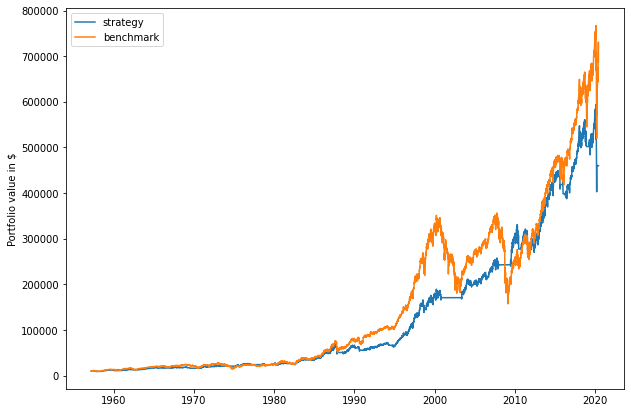

In [20]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

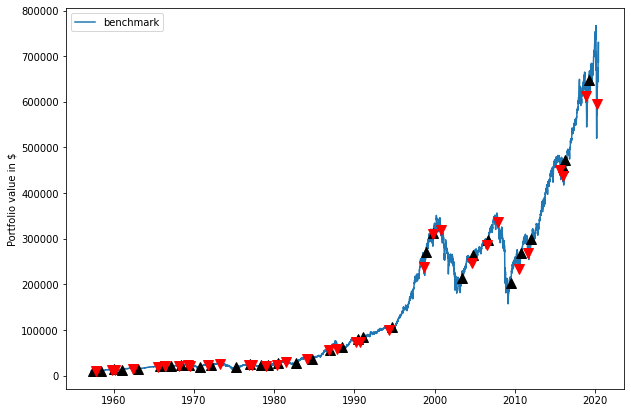

In [21]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [22]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$459,733.37","$687,378.51"
total_net_profit,"$449,733.37","$677,378.51"
gross_profit,"$523,232.94","$677,378.51"
gross_loss,"-$73,499.57",$0.00


,strategy,benchmark
annual_return_rate,6.24,6.91
max_closed_out_drawdown,-32.20,-55.88
drawdown_annualized_return,-5.16,-8.08
drawdown_recovery,-0.09,-1.41
best_month,15.21,21.07
worst_month,-29.42,-29.42
sharpe_ratio,0.68,0.57
sortino_ratio,0.72,0.76
monthly_std,2.99,4.13
avg_month,0.53,0.62


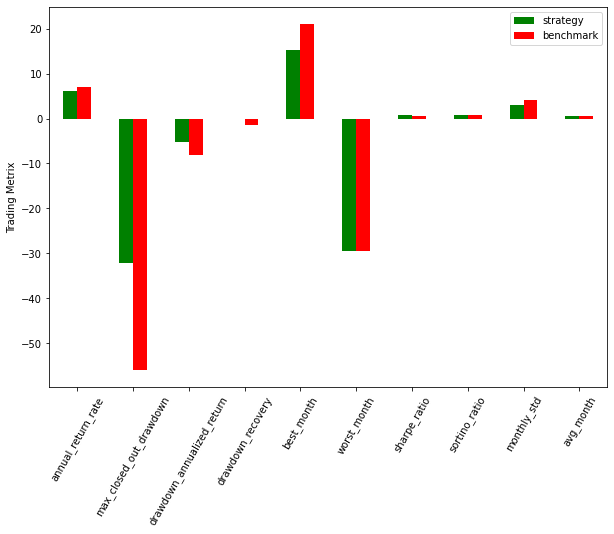

In [23]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df